# Setup

In [1]:
import gc
gc.enable()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow import keras
from keras.applications import efficientnet_v2
from keras.layers import (
    Resizing, RandomFlip, RandomRotation,
    GlobalAveragePooling2D, Dropout, Dense, Input)

from keras.callbacks import EarlyStopping
from keras.utils import set_random_seed

SEED = 2024
set_random_seed(SEED)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# DATA_PATH = '/content/drive/MyDrive/notebooks/swoc_s4/facial_emotion_detection/'
# images = np.load(f'{DATA_PATH}/images.npy')
# labels = np.load(f'{DATA_PATH}/labels.npy')

In [3]:
DATA_PATH = '/kaggle/input/facial-expression'
images = np.load(f'{DATA_PATH}/Facial expression.npy')
labels = np.load(f'{DATA_PATH}/Facial expression label.npy')

# Data preparation

In [4]:
label_mapping = {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'surprised'}

In [5]:
ord_labels = np.argmax(labels, axis=1)

**Test dataset:** (using the same split as the baseline notebook)

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, ord_labels,
    test_size=0.1,
    shuffle=True,
    stratify=ord_labels, # to maintain proportion of classes in test data
    random_state=SEED)

**Train and validation datasets:**

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.1,
    shuffle=True,
    stratify=train_labels, # to maintain proportion of classes in val data
    random_state=SEED)

In [8]:
len(train_labels), len(val_labels), len(test_labels)

(16159, 1796, 1995)

**Data-augmentation (best config chosen from notebook 01):**

In [9]:
data_augmentation = keras.Sequential([
    RandomRotation(factor=(-0.1, 0.2), fill_mode='constant', seed=SEED),
    RandomFlip(mode='horizontal', seed=SEED),
])

# Model training

In [10]:
# common parameters
BASE_LR = 1e-4
DROPOUT = 0.2
PATIENCE = 10
BATCH_SIZE = 32
EPOCHS = 200
VERBOSE = 1

In [11]:
# overfitting detection
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    min_delta=2e-4,
    restore_best_weights=True)

In [12]:
# visualizing training curves
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    num_epochs = len(train_loss)
    epochs = range(num_epochs)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')

    train_stop = (num_epochs-1-PATIENCE, val_accuracy[num_epochs-1-PATIENCE])
    ax[1].annotate(f'Early stopping\ntriggered',
                xy=train_stop, xycoords='data',
                xytext=(-5, -75), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='bottom')

    ax[0].minorticks_on(); ax[1].minorticks_on()
    ax[0].set_xlabel('Epochs'); ax[1].set_xlabel('Epochs')
    ax[0].legend(); ax[1].legend()
    fig.tight_layout()
    plt.show()

### 1. EfficientNetV2S, no data augmentation

In [13]:
img_size = 224

**Feature extraction phase:**

In [14]:
keras.backend.clear_session()
base_model = efficientnet_v2.EfficientNetV2S(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

inputs = Input(shape=(48, 48, 3))
x = Resizing(img_size, img_size, interpolation='lanczos5', crop_to_aspect_ratio=True)(inputs)
x = base_model(x, training=False) # includes preprocessing layer
x = GlobalAveragePooling2D()(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

82420632/82420632 [==============================] - 0s 0us/step


Epoch 1/200
505/505 [==============================] - 107s 182ms/step - loss: 1.1691 - accuracy: 0.4914 - val_loss: 1.0390 - val_accuracy: 0.5980
Epoch 2/200
505/505 [==============================] - 88s 174ms/step - loss: 1.0005 - accuracy: 0.5995 - val_loss: 0.9624 - val_accuracy: 0.6242
Epoch 3/200
505/505 [==============================] - 89s 176ms/step - loss: 0.9427 - accuracy: 0.6268 - val_loss: 0.9248 - val_accuracy: 0.6375
Epoch 4/200
505/505 [==============================] - 87s 172ms/step - loss: 0.9087 - accuracy: 0.6404 - val_loss: 0.8998 - val_accuracy: 0.6526
Epoch 5/200
505/505 [==============================] - 87s 172ms/step - loss: 0.8874 - accuracy: 0.6516 - val_loss: 0.8824 - val_accuracy: 0.6576
Epoch 6/200
505/505 [==============================] - 87s 172ms/step - loss: 0.8696 - accuracy: 0.6600 - val_loss: 0.8688 - val_accuracy: 0.6559
Epoch 7/200
505/505 [==============================] - 87s 172ms/step - loss: 0.8549 - accuracy: 0.6661 - val_loss: 0.8574 

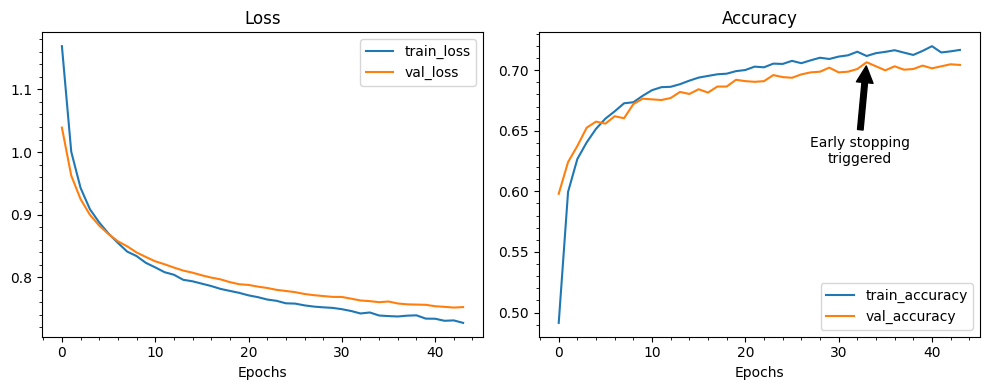

CPU times: user 47min 2s, sys: 34.4 s, total: 47min 36s
Wall time: 1h 4min 35s


In [15]:
%%time
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history)

In [16]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 9s 153ms/step - loss: 0.7618 - accuracy: 0.7066

TEST:
63/63 [==============================] - 10s 161ms/step - loss: 0.7589 - accuracy: 0.7053


[0.7589461803436279, 0.7052631378173828]

63/63 [==============================] - 12s 149ms/step


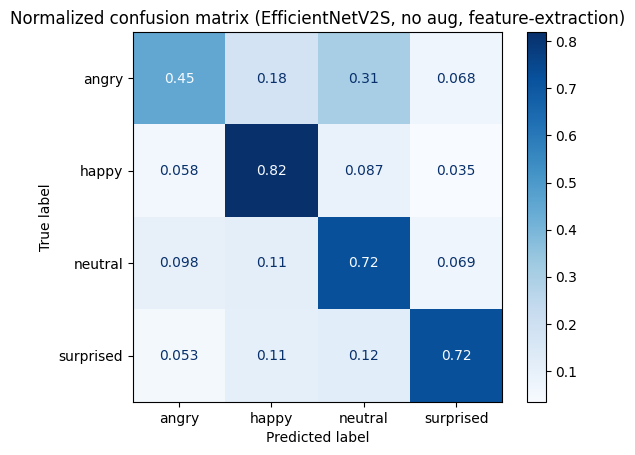

In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (EfficientNetV2S, no aug, feature-extraction)')
plt.show()

**Fine-tuning phase:**

In [18]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Epoch 1/200
505/505 [==============================] - 278s 385ms/step - loss: 0.6252 - accuracy: 0.7619 - val_loss: 0.5745 - val_accuracy: 0.7856
Epoch 2/200
505/505 [==============================] - 190s 376ms/step - loss: 0.4683 - accuracy: 0.8290 - val_loss: 0.5302 - val_accuracy: 0.8174
Epoch 3/200
505/505 [==============================] - 190s 377ms/step - loss: 0.3768 - accuracy: 0.8644 - val_loss: 0.5297 - val_accuracy: 0.8207
Epoch 4/200
505/505 [==============================] - 190s 376ms/step - loss: 0.2877 - accuracy: 0.8994 - val_loss: 0.5241 - val_accuracy: 0.8268
Epoch 5/200
505/505 [==============================] - 190s 377ms/step - loss: 0.2028 - accuracy: 0.9302 - val_loss: 0.5790 - val_accuracy: 0.8296
Epoch 6/200
505/505 [==============================] - 190s 377ms/step - loss: 0.1338 - accuracy: 0.9545 - val_loss: 0.6387 - val_accuracy: 0.8324
Epoch 7/200
505/505 [==============================] - 190s 376ms/step - loss: 0.0766 - accuracy: 0.9756 - val_loss: 0

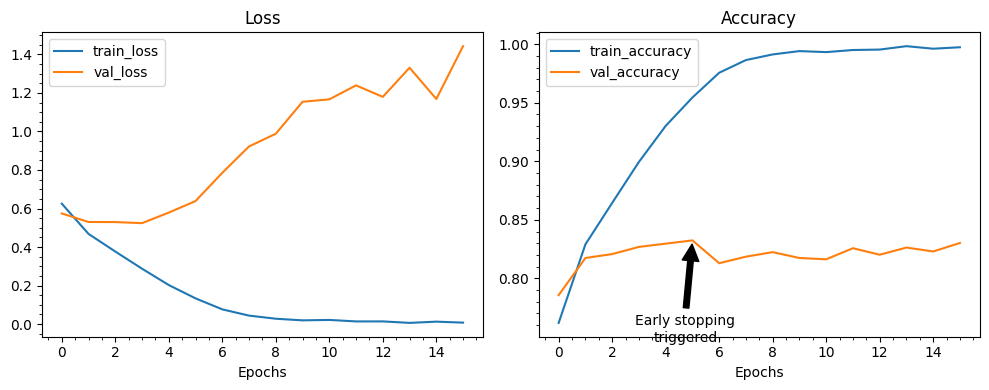

CPU times: user 44min, sys: 3min 52s, total: 47min 53s
Wall time: 52min 11s


In [19]:
%%time
history_ft = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history_ft)

In [20]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 9s 159ms/step - loss: 0.6387 - accuracy: 0.8324

TEST:
63/63 [==============================] - 10s 153ms/step - loss: 0.6643 - accuracy: 0.8231


[0.6643170714378357, 0.8230576515197754]

63/63 [==============================] - 12s 149ms/step


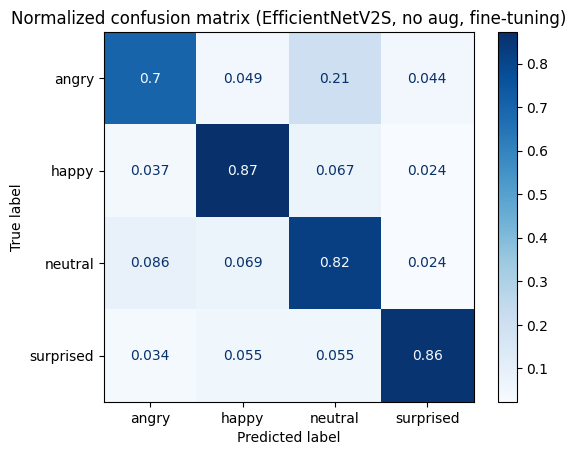

In [21]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (EfficientNetV2S, no aug, fine-tuning)')
plt.show()

### 2. EfficientNetV2S, with data augmentation

**Feature extraction phase:**

In [22]:
keras.backend.clear_session()
base_model = efficientnet_v2.EfficientNetV2S(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

inputs = Input(shape=(48, 48, 3))
x = Resizing(img_size, img_size, interpolation='lanczos5', crop_to_aspect_ratio=True)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(DROPOUT)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Epoch 1/200
505/505 [==============================] - 105s 181ms/step - loss: 1.2593 - accuracy: 0.4250 - val_loss: 1.1119 - val_accuracy: 0.5278
Epoch 2/200
505/505 [==============================] - 88s 174ms/step - loss: 1.1112 - accuracy: 0.5334 - val_loss: 1.0240 - val_accuracy: 0.5802
Epoch 3/200
505/505 [==============================] - 88s 174ms/step - loss: 1.0521 - accuracy: 0.5673 - val_loss: 0.9807 - val_accuracy: 0.6013
Epoch 4/200
505/505 [==============================] - 88s 174ms/step - loss: 1.0155 - accuracy: 0.5832 - val_loss: 0.9569 - val_accuracy: 0.6114
Epoch 5/200
505/505 [==============================] - 88s 174ms/step - loss: 0.9886 - accuracy: 0.5969 - val_loss: 0.9379 - val_accuracy: 0.6203
Epoch 6/200
505/505 [==============================] - 89s 175ms/step - loss: 0.9772 - accuracy: 0.5998 - val_loss: 0.9241 - val_accuracy: 0.6253
Epoch 7/200
505/505 [==============================] - 88s 174ms/step - loss: 0.9643 - accuracy: 0.6036 - val_loss: 0.9125 

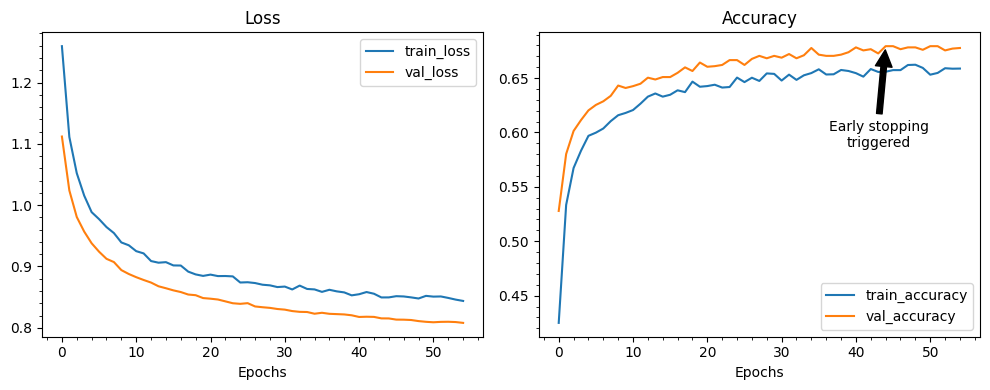

CPU times: user 59min 33s, sys: 49.8 s, total: 1h 22s
Wall time: 1h 21min 5s


In [23]:
%%time
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history)

In [24]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 9s 155ms/step - loss: 0.8153 - accuracy: 0.6793

TEST:
63/63 [==============================] - 10s 156ms/step - loss: 0.8342 - accuracy: 0.6747


[0.8341718316078186, 0.6746867299079895]

63/63 [==============================] - 13s 149ms/step


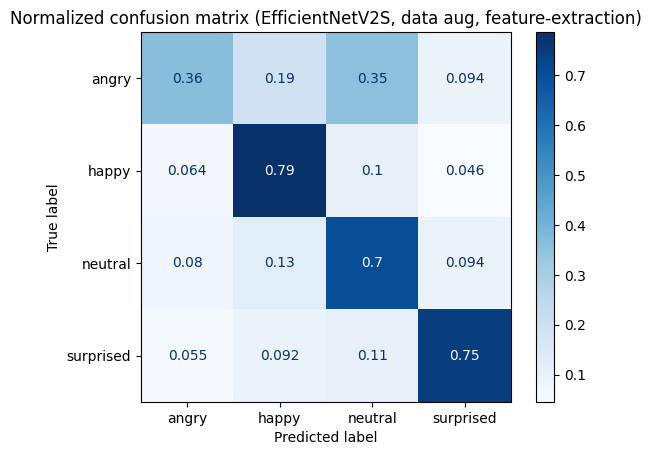

In [25]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (EfficientNetV2S, data aug, feature-extraction)')
plt.show()

**Fine-tuning phase:**

In [26]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

Epoch 1/200
505/505 [==============================] - 279s 391ms/step - loss: 0.7269 - accuracy: 0.7117 - val_loss: 0.6256 - val_accuracy: 0.7589
Epoch 2/200
505/505 [==============================] - 194s 384ms/step - loss: 0.5873 - accuracy: 0.7798 - val_loss: 0.5640 - val_accuracy: 0.7884
Epoch 3/200
505/505 [==============================] - 194s 385ms/step - loss: 0.5118 - accuracy: 0.8057 - val_loss: 0.5602 - val_accuracy: 0.7962
Epoch 4/200
505/505 [==============================] - 194s 384ms/step - loss: 0.4637 - accuracy: 0.8262 - val_loss: 0.5100 - val_accuracy: 0.8224
Epoch 5/200
505/505 [==============================] - 194s 384ms/step - loss: 0.4155 - accuracy: 0.8464 - val_loss: 0.5131 - val_accuracy: 0.8213
Epoch 6/200
505/505 [==============================] - 194s 385ms/step - loss: 0.3738 - accuracy: 0.8617 - val_loss: 0.4901 - val_accuracy: 0.8302
Epoch 7/200
505/505 [==============================] - 194s 384ms/step - loss: 0.3424 - accuracy: 0.8752 - val_loss: 0

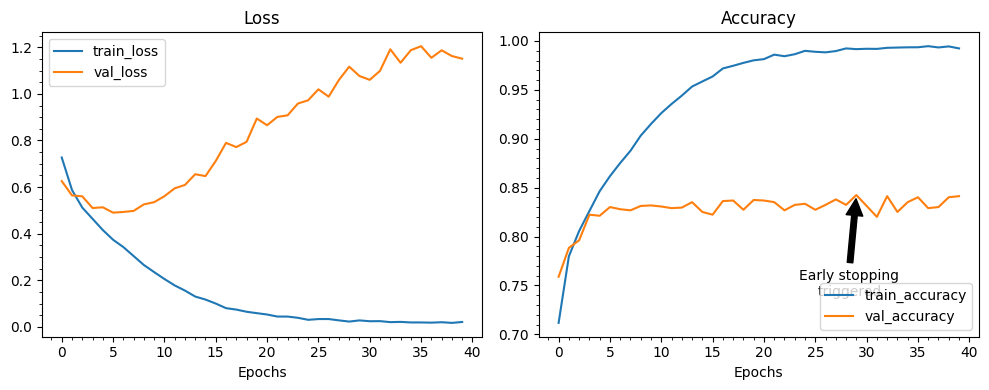

CPU times: user 1h 49min 58s, sys: 10min 1s, total: 1h 59min 59s
Wall time: 2h 10min 48s


In [27]:
%%time
history_ft = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=VERBOSE)

plot_training_curve(history_ft)

In [28]:
print('VALIDATION:')
model.evaluate(val_images, val_labels)
print('\nTEST:')
model.evaluate(test_images, test_labels)

VALIDATION:
57/57 [==============================] - 9s 153ms/step - loss: 1.0766 - accuracy: 0.8424

TEST:
63/63 [==============================] - 10s 156ms/step - loss: 1.0805 - accuracy: 0.8286


[1.0805283784866333, 0.8285714387893677]

63/63 [==============================] - 13s 149ms/step


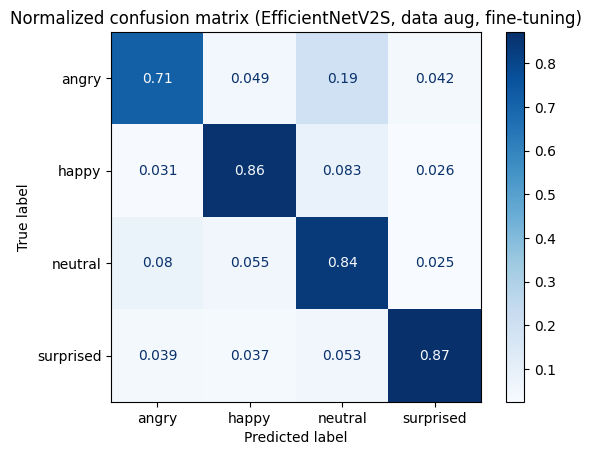

In [29]:
predictions = np.argmax(model.predict(test_images), axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predictions,
    display_labels=label_mapping.values(),
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix (EfficientNetV2S, data aug, fine-tuning)')
plt.show()